# Data Measurements of Images of Handwritten Digits

---

This notebook compares several methods of measuring "relevance" and "diversity" in MNIST data between a data buyer and one or more possible data sellers in a private and federated manner.

The basic algorithm is 
1. The buyer has some reference data and compute PCA to get principal directions
2. The buyer sends these directions to each seller
3. The seller projects their data onto these directions
4. The seller measures some relevance and diversity on the projected data and sends back these measurements to the buyer
5. The buyer compares relevance and diversity measurements between sellers (and chooses to buy data from the seller with the "best" relevance and diversity values)

Definitions of relevance include:
* [Volume overlap](https://arxiv.org/abs/2208.12354)
* Cosine similarity
* Euclidean distance 

Definitions of diversity include:
* [Volume](https://github.com/ZhaoxuanWu/VolumeBased-DataValuation)
* [Vendi Score](https://github.com/vertaix/Vendi-Score)
* [Dispersion of the features](https://arxiv.org/abs/2003.08529)

For more information see this [paper](https://ojs.aaai.org/index.php/AAAI/article/view/26106) for more details.

## Setup


Set `USE_COLAB = True` if runnning on [Google Colab](https://colab.research.google.com/) otherwise left as is.

In [1]:
USE_COLAB = False

if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/data-valuation/
    !pip install -qr requirements.txt

### Module imports

In [2]:
import math
import os
import sys
from collections import defaultdict
from importlib import reload
from pathlib import Path

import clip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from torchvision.datasets import (
    CIFAR10,
    EMNIST,
    KMNIST,
    MNIST,
    PCAM,
    QMNIST,
    SEMEION,
    STL10,
    SVHN,
    FashionMNIST,
)
from torchvision.models import (
    ResNet18_Weights,
    ResNet34_Weights,
    ResNet50_Weights,
    resnet18,
    resnet34,
    resnet50,
)
from torchvision.transforms import Compose, Lambda, Resize, ToPILImage, ToTensor
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.style.use("bmh")
plt.rcParams.update({"font.family": "serif"})
fig_dir = Path("../figures")

# local imports
sys.path.append("../src")
import utils
import valuation
from data import simple_DS, subset
from valuation import get_measurements

### Load datasets

In [3]:
# Path to data directory
root = Path("../../data/")

# dowload data if dataset does not exist in data directory
download = True

mnist = MNIST(root=root, train=True, download=download)
fashion = FashionMNIST(root=root, train=True, download=download)
cifar = CIFAR10(root=root, train=True, download=download)
emnist = EMNIST(root=root, split="byclass", train=True, download=download)
svhn = SVHN(root=root, split="train", download=download)
kmnist = KMNIST(root=root, train=True, download=download)
# semeion = SEMEION(root=root, download=download)
qmnist = QMNIST(root=root, train=True, download=download)
# stl = STL10(root=root, split="train", download=download)

Files already downloaded and verified
Using downloaded and verified file: ../../data/train_32x32.mat


#### Load MNIST-M dataset

[https://paperswithcode.com/dataset/mnist-m](https://paperswithcode.com/dataset/mnist-m)

In [4]:
mnist_m_dir = Path("../../data/mnist_m/")

if (mnist_m_dir / "mnist_m_train.pt").exists():
    mnist_m_data = torch.load(mnist_m_dir / "mnist_m_train.pt")
else:
    mnist_m_df = pd.read_csv(
        mnist_m_dir / "mnist_m_train_labels.txt",
        sep=" ",
        header=None,
        names=["image", "label"],
    )
    mnist_m_images = np.stack(
        [
            np.array(Image.open(mnist_m_dir / "mnist_m_train" / img))
            for img in tqdm(mnist_m_df.image.values)
        ]
    )

    mnist_m_data = {"images": mnist_m_images, "labels": mnist_m_df.label.values}
    torch.save(mnist_m_data, mnist_m_dir / "mnist_m_train.pt")

mnist_m_images = mnist_m_data["images"]
mnist_m_labels = mnist_m_data["labels"]

In [5]:
datasets = {
    "MNIST": {"images": mnist.data, "labels": mnist.targets},
    "QMNIST": {"images": qmnist.data, "labels": qmnist.targets},
    "EMNIST": {"images": emnist.data, "labels": emnist.targets},
    "KMNIST": {"images": kmnist.data, "labels": kmnist.targets},
    # "SEMEION": {"images": semeion.data, "labels": semeion.labels},
    "Fashion": {"images": fashion.data, "labels": fashion.targets},
    "MNIST-M": {"images": np.moveaxis(mnist_m_images, -1, 1), "labels": mnist_m_labels},
    "SVHN": {"images": svhn.data, "labels": svhn.labels},
    "CIFAR10": {"images": np.moveaxis(cifar.data, -1, 1), "labels": cifar.targets},
    # "STL10": {"images": stl.data, "labels": stl.labels},
}
for name, data in datasets.items():
    datasets[name] = {k: torch.tensor(v) for k, v in data.items()}

/tmp/ipykernel_52784/4173801860.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datasets[name] = {k: torch.tensor(v) for k, v in data.items()}


In [6]:
for k, v in datasets.items():
    print(k.ljust(10), v["images"].shape)

MNIST      torch.Size([60000, 28, 28])
QMNIST     torch.Size([60000, 28, 28])
EMNIST     torch.Size([697932, 28, 28])
KMNIST     torch.Size([60000, 28, 28])
Fashion    torch.Size([60000, 28, 28])
MNIST-M    torch.Size([59001, 3, 32, 32])
SVHN       torch.Size([73257, 3, 32, 32])
CIFAR10    torch.Size([50000, 3, 32, 32])


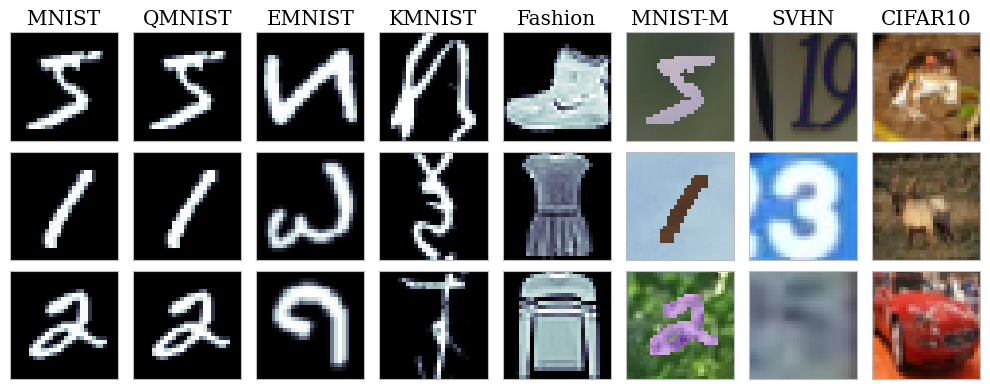

In [7]:
num_to_plot = [0, 3, 5]

fig, axes = plt.subplots(len(num_to_plot), len(datasets), figsize=(10, 4))
for j, (name, data) in enumerate(datasets.items()):
    for i, k in enumerate(num_to_plot):
        img = data["images"][k]
        if img.ndim == 3:
            img = img.moveaxis(0, -1)
            axes[i, j].imshow(img)
        else:
            axes[i, j].imshow(img, cmap=plt.cm.bone)
        axes[i, j].grid(False)
        if i == 0:
            axes[i, j].set_title(name)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
fig.tight_layout()
plt.savefig(fig_dir / f"mnist-images.eps", bbox_inches='tight')
plt.show()

### Embed image data through pretrained model

This step may take awhile depending on how many images you are embedding

In [8]:
# Set to directory of precomputed embeddings
saved_embedding_path = Path("../embeddings")

In [9]:
temp_embedding_dict = {
    k: torch.load(saved_embedding_path / f"clip_embedding_{k}.pt")
    for k in datasets.keys()
}

In [10]:
# if already computed and saved embeddings, set to True
use_precomputed_embeddings = True

if use_precomputed_embeddings:
    embedding_dict = {
        k: torch.load(saved_embedding_path / f"clip_embedding_{k}.pt")
        for k in datasets.keys()
    }
else:
    # speed up by reducing number of samples to embed 
    num_samples = 60000

    # choose a pretrained embedding model (default clip)
    use_clip = True

    # batch size (default 16)
    batch_size = 16

    assert torch.cuda.is_available()
    if use_clip:
        model, preprocess = clip.load("ViT-B/16", device="cuda")
        trans = Compose([ToPILImage(), preprocess])
        embedding_func = model.encode_image
    else:
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
        trans = Compose(
            [
                ToPILImage(),
                Lambda(lambda x: x.convert("RGB")),
                Resize(size=224),
                ToTensor(),
            ]
        )
        embedding_func = model

    make_loader = lambda x, y=None, batch_size=batch_size: torch.utils.data.DataLoader(
        simple_DS(x, labels=y, transforms=trans),
        batch_size=batch_size,
    )

    embedding_dict = {}
    for name, data in datasets.items():
        print(name.center(40, "-"))
        loader = make_loader(
            data["images"][:num_samples], y=data["labels"][:num_samples]
        )
        temp = defaultdict(list)
        for x, y in tqdm(loader):
            temp["embeddings"].append(embedding_func(x.cuda()).detach().cpu())
            temp["labels"].append(y)

        temp["embeddings"] = torch.cat(temp["embeddings"])
        temp["labels"] = torch.cat(temp["labels"])
        embedding_dict[name] = dict(temp)

    for k, v in embedding_dict.items():
        torch.save(v, saved_embedding_path / f"clip_embedding_{k}.pt")

### Noise seller for baseline

Generate sythethic data using Gaussian distribution

In [12]:
match_dist = embedding_dict['MNIST']['embeddings']

In [13]:
noise_mean = match_dist.mean(0)
noise_std = match_dist.std(0).mean() * torch.ones(noise_mean.shape[0])
num_samples = 60000
noise_seller = np.random.multivariate_normal(noise_mean, torch.diag(noise_std), size=num_samples)

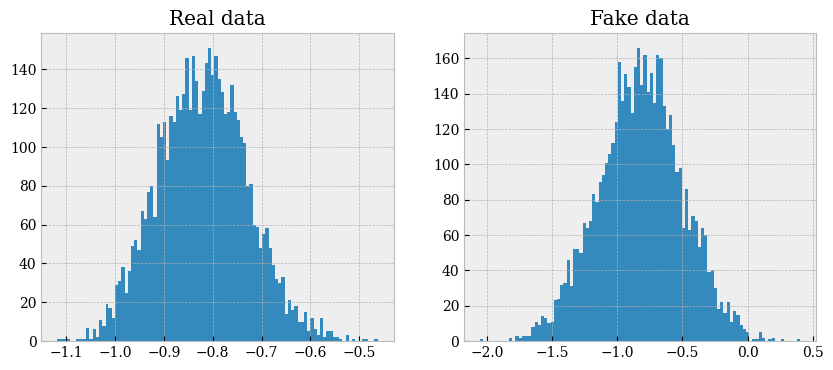

In [14]:
dim = 1
k = 5000

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(match_dist[:k, dim], bins=100)
ax[1].hist(noise_seller[:k, dim], bins=100)
ax[0].set_title('Real data')
ax[1].set_title('Fake data')
plt.show()

In [15]:
embedding_dict['Noise'] = {'embeddings': noise_seller}

### Randomly split into buyer and sellers dataset

In [16]:
def random_split(data, num_buyer, num_seller, random_seed=0):
    seller_data, buyer_data = train_test_split(
        data, test_size=num_buyer, random_state=random_seed
    )
    return dict(seller_data=seller_data[:num_seller], buyer_data=buyer_data)

In [17]:
# assume buyer has 1000 images and seller has 50000 for now, will vary later
num_buyer = 1000
num_seller = 50000

split_data = {
    k: random_split(v["embeddings"], num_buyer=num_buyer, num_seller=num_seller)
    for k, v in embedding_dict.items()
}
buyer_data = {k: v["buyer_data"] for k, v in split_data.items()}
seller_data = {k: v["seller_data"] for k, v in split_data.items()}

### PCA of buyer data

Use PCA projection from the buyer to send to the sellers

In [18]:
# Choose one of these datasets for the buyer
buyer_data.keys()

dict_keys(['MNIST', 'QMNIST', 'EMNIST', 'KMNIST', 'Fashion', 'MNIST-M', 'SVHN', 'CIFAR10', 'Noise'])

In [19]:
# For example, if the buyer has MNIST data
buyer = "MNIST"
X_b = buyer_data[buyer]

# Covariance matrix
cov_b = np.cov(X_b, rowvar=False)

# Eigendecomposition of buyer's covariance
eigvals, eigvecs = np.linalg.eigh(cov_b)

# Sort by decreasing order
index = np.argsort(eigvals)[::-1]
sorted_eigvals = eigvals[index]
sorted_eigvecs = eigvecs[:, index]

In [20]:
# number of components to use (can check Scree plot for "elbow")
num_components = 10

# plt.plot(sorted_eigvals[:num_components])

print(
    "First ten principal components of the buyer",
    *np.linalg.norm(cov_b @ sorted_eigvecs[:, :num_components], axis=0).round(4),
    sep="\n"
)

First ten principal components of the buyer
1.0635
0.8383
0.4283
0.3374
0.2579
0.2489
0.1815
0.1711
0.1444
0.113


#### Can also use Sklearn's to do PCA but need to clear mean for seller's data

In [21]:
pca = PCA(n_components=num_components, svd_solver="randomized", whiten=False)
pca.fit(X_b)
print(pca.explained_variance_)
pca.mean_ = None  # clear previosuly fitted mean from buyer

[1.06354448 0.83829385 0.42833063 0.33739476 0.25786033 0.24891709
 0.18152031 0.17105893 0.14443346 0.11298652]


In [22]:
# Seller projected principal components
for k, v in seller_data.items():
    # if k == buyer: continue
    X_s = v
    cov_s = np.cov(X_s, rowvar=False)
    print(
        k.ljust(8),
        np.linalg.norm(cov_s @ sorted_eigvecs[:, :num_components], axis=0).round(4),
    )

MNIST    [0.9987 0.771  0.4136 0.3117 0.2627 0.2377 0.163  0.1728 0.1512 0.1142]
QMNIST   [0.9973 0.7684 0.4144 0.3124 0.2639 0.238  0.1623 0.1733 0.1506 0.1149]
EMNIST   [0.8215 0.3944 0.1839 0.3997 0.2029 0.1465 0.1692 0.1898 0.2464 0.1249]
KMNIST   [1.4054 0.7816 0.2237 0.5021 0.2942 0.438  0.1694 0.2964 0.2902 0.3291]
Fashion  [0.3647 0.4116 0.1768 0.3117 0.2876 0.2151 0.2592 0.3373 0.2871 0.2676]
MNIST-M  [0.8806 0.936  0.5258 0.9842 0.5575 0.5853 0.4368 0.5372 0.5498 0.5166]
SVHN     [0.3519 1.667  0.3493 0.4886 0.5151 0.3781 0.4233 0.3441 0.3086 0.4195]
CIFAR10  [0.6618 0.2843 0.1836 0.5535 0.6645 0.2331 1.0317 0.2591 0.3727 0.337 ]
Noise    [0.1009 0.1015 0.1005 0.1014 0.1009 0.1015 0.1    0.1008 0.1004 0.1012]


## Data measurements with relevance and diversity 

**Relevance measures**
1. L2 (Euclidean) distance between mean vectors of buyer and seller $\lvert\lvert \hat{X}_b -  \hat{X}_s \rvert\rvert_2$
2. Cosine similarity $\frac{\hat{X}_b \cdot \hat{X}_s}{\lvert\lvert \hat{X}_s\rvert\rvert \lvert\lvert \hat{X}_b\rvert\rvert}$
3. Volume overlap $\prod_{c\in C} \frac{\min\left(\lambda^b_c, \lambda^s_c\right)}{\max\left(\lambda^b_c, \lambda^s_c\right)}$, where $C$ is the number of components

**Diversity measures**
1. Volume $\log \det(X_s^\top X_s) = \sum_c \log \lambda^s_c$
2. Vendi Score $\exp\left(-\mathrm{tr}\left(\frac{K}{n} \log \frac{K}{n}\right)\right) = \exp\left(-\sum_{c}^C \lambda_c^s \log \lambda_c^s\right)$, where $K$ is a similarity matrix e.g. covariance
3. Dispersion/deviation of features $\frac{1}{D}\sum_d^D \sqrt{X_d^2 - \mathbb{E}[X_d]^2}$



In [23]:
sellers = list(seller_data.keys())
X_s = seller_data[sellers[0]]

### Compare sellers with difference combinations of measures

Assume the buyer has MNIST data

In [24]:
buyer = "MNIST"
X_b = buyer_data[buyer]

# number of principal components to use
n_components = 10

measures = {}
for seller, X_s in seller_data.items():
    measures[seller] = get_measurements(
        X_b,
        X_s,
        n_components=n_components,
    )

In [25]:
# Consistent coloring
seller_color = {
    "MNIST": "C0",
    "QMNIST": "C1",
    "MNIST-M": "C2",
    "EMNIST": "C3",
    "KMNIST": "C4",
    "SVHN": "C5",
    "SEMEION": "C6",
    "Fashion": "C7",
    "CIFAR10": "C8",
    "STL10": "C9",
    "Noise": "gray",
}

id_sellers = {"MNIST", "MNIST-M", "QMNIST", "EMNIST", "KMNIST", "SVHN"}
ood_sellers = set(sellers) - id_sellers

marker_size = 200

def get_marker(
        seller, buyer=buyer, 
        id_sellers=id_sellers,
        buyer_marker = "*",
        id_marker = "o",
        ood_marker = "X",
    ):
    if seller == buyer:
        marker = buyer_marker
    elif seller in id_sellers:
        marker = id_marker
    else:
        marker = ood_marker
    return marker

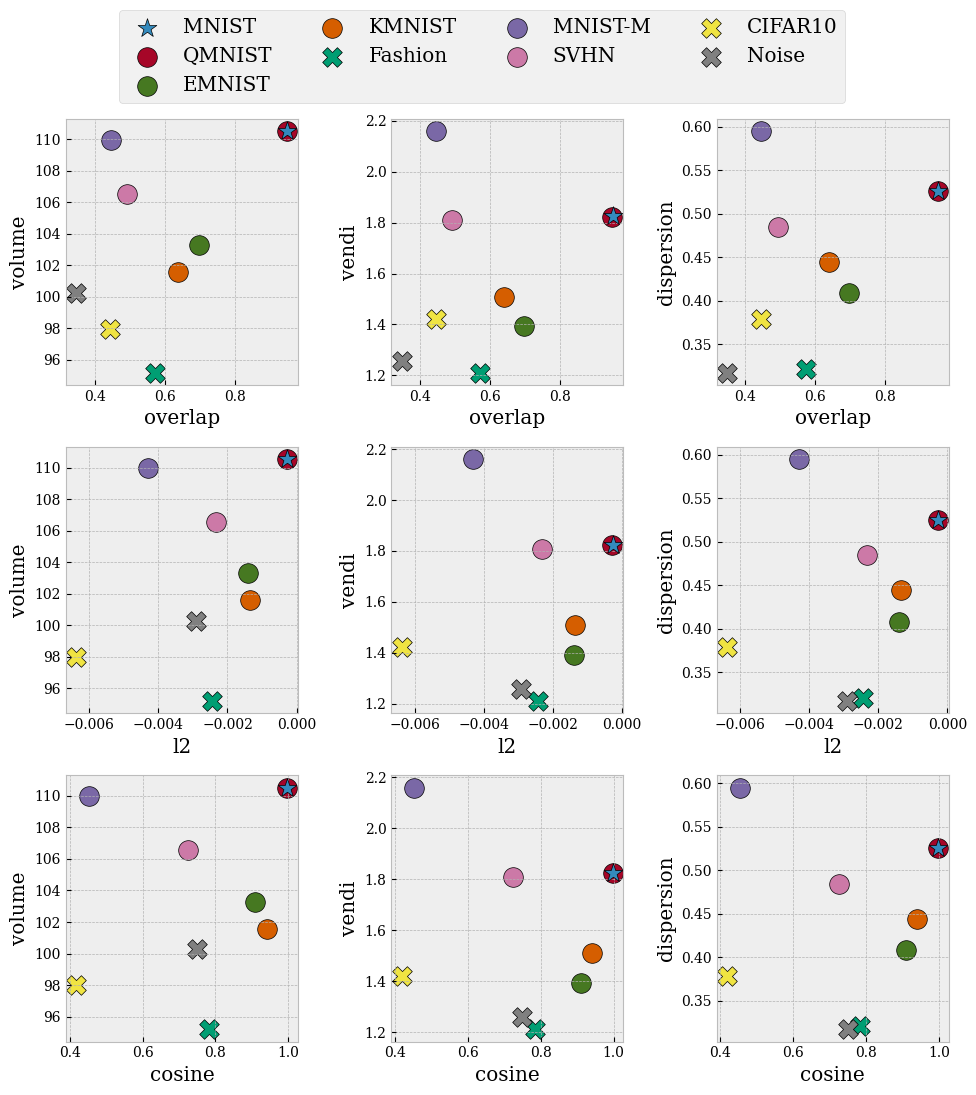

In [26]:
# Plot in-domain and out-of-domain sellers

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
rel = "overlap"
for i, rel in enumerate(["overlap", "l2", "cosine"]):
    for j, div in enumerate(["volume", "vendi", "dispersion"]):
        for k, v in measures.items():
            label = k if i == j == 0 else None
            axes[i, j].scatter(
                v[rel],
                v[div],
                label=label,
                s=marker_size,
                marker=get_marker(k),
                edgecolor="k",
                c=seller_color[k],
                zorder=2 if k == buyer else 1,
            )
        axes[i, j].set_xlabel(rel, fontsize="x-large")
        axes[i, j].set_ylabel(div, fontsize="x-large")

fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncols=len(sellers) // 2,
    fontsize="x-large",
)
fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


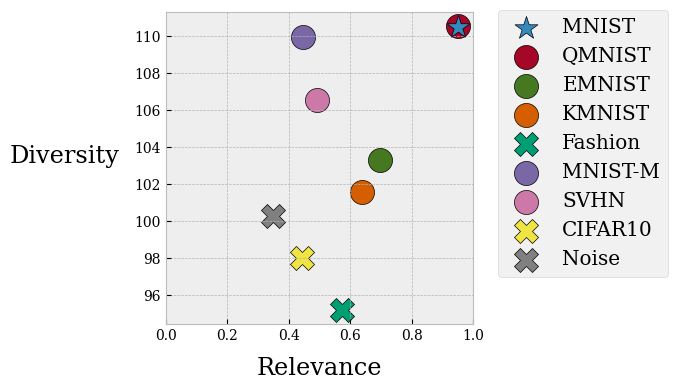

In [28]:
plt.figure(figsize=(7, 4))
for k, v in measures.items():
    marker = get_marker(k)
    plt.scatter(
        v["overlap"],
        v["volume"],
        label=k,
        s=300,
        marker=get_marker(k),
        edgecolor="k",
        c=seller_color[k],
        zorder=2 if k == buyer else 1,
    )
plt.xlabel("Relevance", fontsize="xx-large", labelpad=10)
plt.ylabel("Diversity", fontsize="xx-large", labelpad=50, rotation=0)
plt.xlim(0, 1.0)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.05, 1.04),
    # ncols=len(sellers) // 2,
    fontsize="x-large",
)
plt.tight_layout(w_pad=6)
plt.savefig(fig_dir / f"mnist-diversity-relevance.eps", bbox_inches='tight')
plt.show()

### Vary amount of seller data 

Now try changing amount of seller data to determine effect of diversity and relevance

In [29]:
# Fix buyer to 1000 samples
num_buyer = 1000

# Total number of seller data for each dataset
num_seller = 50000

split_data = {
    k: random_split(v["embeddings"], num_buyer=num_buyer, num_seller=num_seller)
    for k, v in embedding_dict.items()
}
buyer_data = {k: v["buyer_data"] for k, v in split_data.items()}
seller_data = {k: v["seller_data"] for k, v in split_data.items()}

# select buyer
buyer = "MNIST"
X_b = buyer_data[buyer]

In [30]:
# vary number of samples in each seller
range_seller_samples = [
    10,
    25,
    50,
    75,
    100,
    250,
    500,
    1000,
    2500,
    5000,
    10000,
    25000,
    50000,
]

# number of components
n_components = 10

In [31]:
vary_seller_measures = {}
for k, X_s in seller_data.items():
    print(k.center(40, "-"))
    vary_seller_measures[k] = {
        num_sell: get_measurements(
            X_b,
            X_s[:num_sell],
            n_components=n_components,
        )
        for num_sell in tqdm(range_seller_samples)
    }

-----------------MNIST------------------


  0%|          | 0/13 [00:00<?, ?it/s]

-----------------QMNIST-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

-----------------EMNIST-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

-----------------KMNIST-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

----------------Fashion-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

----------------MNIST-M-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

------------------SVHN------------------


  0%|          | 0/13 [00:00<?, ?it/s]

----------------CIFAR10-----------------


  0%|          | 0/13 [00:00<?, ?it/s]

-----------------Noise------------------


  0%|          | 0/13 [00:00<?, ?it/s]

In [32]:
plot_kwargs = dict(
    ls='--',
    markersize=10,
    # markeredgecolor="k",
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


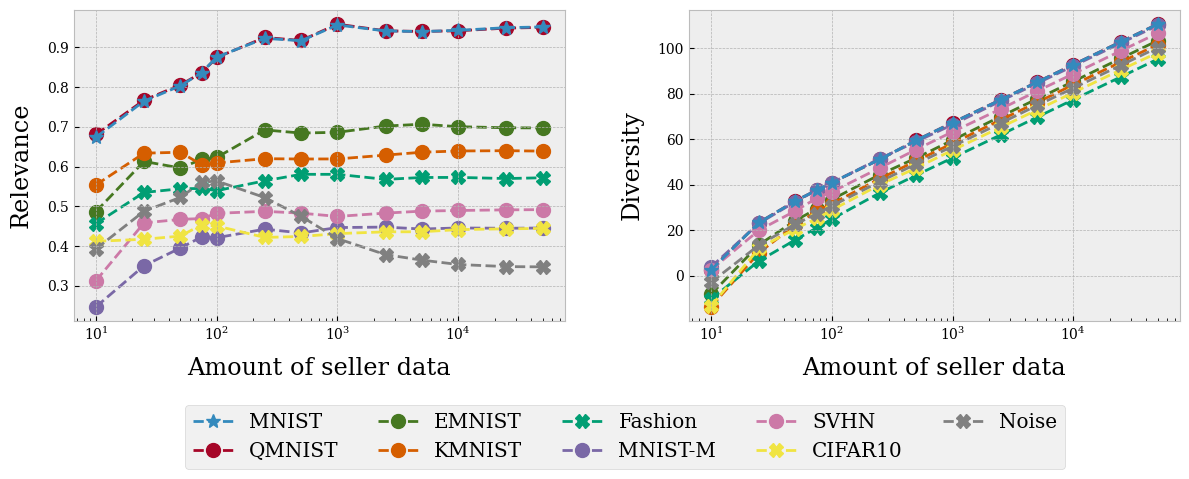

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for seller, meas in vary_seller_measures.items():
    ax[0].plot(
        meas.keys(),
        list(v["overlap"] for v in meas.values()),
        label=seller,
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,
    )
ax[0].set_xlabel("Amount of seller data", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
ax[0].set_xscale("log")
for seller, meas in vary_seller_measures.items():
    ax[1].plot(
        meas.keys(),
        list(v["volume"] for v in meas.values()),
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,
    )
ax[1].set_ylabel("Diversity", labelpad=10, fontsize='xx-large')
ax[1].set_xlabel("Amount of seller data", labelpad=10, fontsize='xx-large')
ax[1].set_xscale("log")
fig.legend(bbox_to_anchor=(0.9, 0.0), fontsize='x-large', ncols=len(sellers)//2 + 1, fancybox=True)
fig.tight_layout(w_pad=4)
plt.savefig(fig_dir / f"mnist-vary-seller.eps", bbox_inches='tight')
plt.show()

### Vary amount of buyer data 

Now try changing amount of buyer data to determine effect of diversity and relevance

In [34]:
num_buyer = 30000
num_seller = 10000

split_data = {
    k: random_split(v["embeddings"], num_buyer=num_buyer, num_seller=num_seller)
    for k, v in embedding_dict.items()
}
buyer_data = {k: v["buyer_data"] for k, v in split_data.items()}
seller_data = {k: v["seller_data"] for k, v in split_data.items()}

buyer = "MNIST"
X_b = buyer_data[buyer]

In [35]:
range_buyer_samples = [
    10,
    25,
    50,
    75,
    100,
    250,
    500,
    1000,
    2500,
    5000,
    10000,
    25000,
]

vary_buyer_measures = {}
for k, X_s in seller_data.items():
    print(k.center(40, "-"))
    vary_buyer_measures[k] = {
        num_buy: get_measurements(
            X_b[:num_buy],
            X_s,
            n_components=n_components,
        )
        for num_buy in tqdm(range_buyer_samples)
    }

-----------------MNIST------------------


  0%|          | 0/12 [00:00<?, ?it/s]

-----------------QMNIST-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

-----------------EMNIST-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

-----------------KMNIST-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

----------------Fashion-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

----------------MNIST-M-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

------------------SVHN------------------


  0%|          | 0/12 [00:00<?, ?it/s]

----------------CIFAR10-----------------


  0%|          | 0/12 [00:00<?, ?it/s]

-----------------Noise------------------


  0%|          | 0/12 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


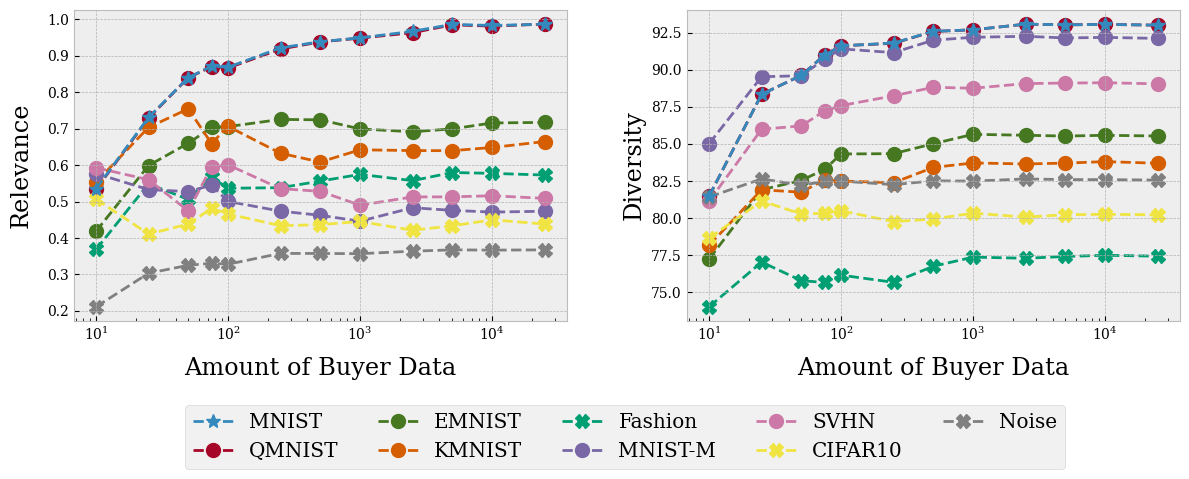

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for seller, meas in vary_buyer_measures.items():
    ax[0].plot(
        meas.keys(),
        list(v["overlap"] for v in meas.values()),
        label=seller,
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,
    )
ax[0].set_xlabel("Amount of Buyer Data", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
ax[0].set_xscale("log")
for seller, meas in vary_buyer_measures.items():
    ax[1].plot(
        meas.keys(),
        list(v["volume"] for v in meas.values()),
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,
    )
ax[1].set_ylabel("Diversity", fontsize='xx-large')
ax[1].set_xlabel("Amount of Buyer Data", labelpad=10, fontsize='xx-large')
ax[1].set_xscale("log")
fig.legend(bbox_to_anchor=(0.9, 0.0), fontsize='x-large', ncols=len(sellers)//2 + 1, fancybox=True)
fig.tight_layout(w_pad=4)
plt.savefig(fig_dir / f"mnist-vary-buyer.eps", bbox_inches='tight')
plt.show()

### Vary amount of components

In [37]:
num_buyer = 1000
num_seller = 10000

split_data = {
    k: random_split(v["embeddings"], num_buyer=num_buyer, num_seller=num_seller)
    for k, v in embedding_dict.items()
}
buyer_data = {k: v["buyer_data"] for k, v in split_data.items()}
seller_data = {k: v["seller_data"] for k, v in split_data.items()}

buyer = "MNIST"
X_b = buyer_data[buyer]

In [38]:

range_comp_samples = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

vary_comp_measures = {}
for k, X_s in seller_data.items():
    print(k.center(40, "-"))
    vary_comp_measures[k] = {
        n_components: get_measurements(
            X_b,
            X_s,
            n_components=n_components,
        )
        for n_components in tqdm(range_comp_samples)
    }


-----------------MNIST------------------


  0%|          | 0/10 [00:00<?, ?it/s]

-----------------QMNIST-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

-----------------EMNIST-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

-----------------KMNIST-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

----------------Fashion-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

----------------MNIST-M-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

------------------SVHN------------------


  0%|          | 0/10 [00:00<?, ?it/s]

----------------CIFAR10-----------------


  0%|          | 0/10 [00:00<?, ?it/s]

-----------------Noise------------------


  0%|          | 0/10 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


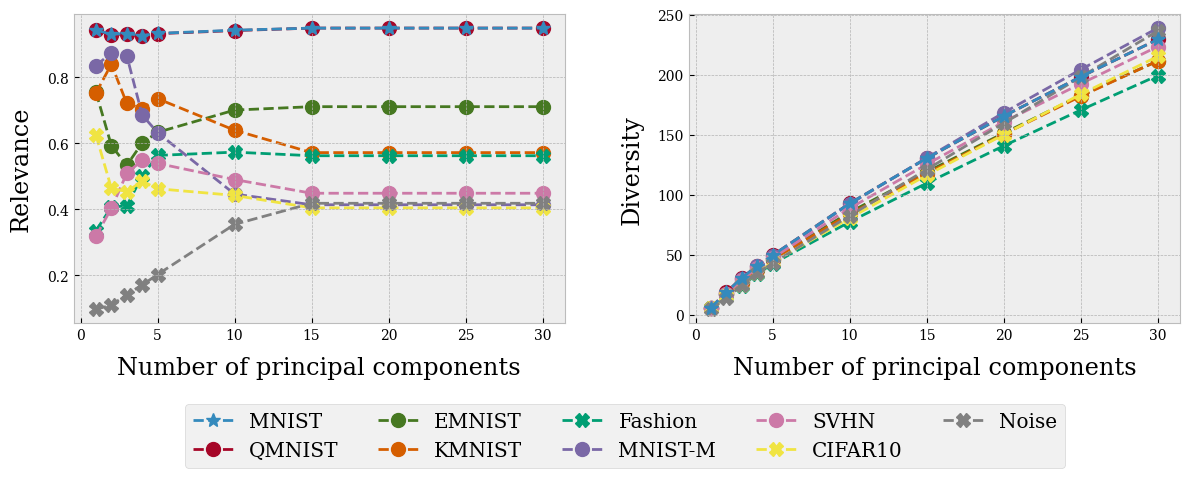

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for seller, meas in vary_comp_measures.items():
    ax[0].plot(
        meas.keys(),
        list(v["overlap"] for v in meas.values()),
        label=seller,
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,

    )
ax[0].set_xlabel("Number of principal components", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
# ax[0].set_xscale("log")
for seller, meas in vary_comp_measures.items():
    ax[1].plot(
        meas.keys(),
        list(v["volume"] for v in meas.values()),
        c=seller_color[seller],
        marker=get_marker(seller),
        zorder=2 if seller == buyer else 1,
        **plot_kwargs,
    )
ax[1].set_xlabel("Number of principal components", labelpad=10, fontsize='xx-large')
ax[1].set_ylabel("Diversity", labelpad=10, fontsize='xx-large')
# ax[1].set_xscale("log")
fig.legend(bbox_to_anchor=(0.9, 0.0), fontsize='x-large', ncols=len(sellers)//2 + 1, fancybox=True)
fig.tight_layout(w_pad=4)
plt.savefig(fig_dir / f"mnist-vary-comp.eps", bbox_inches='tight')
plt.show()